# Assessing data merging techniques

The CIMR retrieval is supposed to combine observations from different sensors. The underlying network must therefore be able to merge the branches that process the inputs. This notebooks explores different approaches for doing this.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

We use a synthetic data set to test the ability of different NNs to merge information from different sources. The retrieval inputs are random fields whose spatial variability is limited to wavelengths from separate spectral bands. The retrieval output is simply the sum of these inputs. In addition to that, the input for each sensor is corrupted with random noise.

In [4]:
from cimr.data.training_data import SuperpositionDataset
from cimr.data.training_data import StreamData, sparse_collate
from torch.utils.data import DataLoader
training_data = SuperpositionDataset(size=128, n_samples=1000, availability=[0.1, 1.0, 0.1], n_steps=8, sparse=True, composition="prod")
training_loader = DataLoader(
    training_data,
    num_workers=8,
    batch_size=2,
    shuffle=True,
    worker_init_fn=training_data.init_rng,
    collate_fn=sparse_collate
)

validation_data = SuperpositionDataset(size=128, n_samples=100, availability=1.0, n_steps=8, composition="prod")
validation_loader = DataLoader(
    validation_data,
    num_workers=8,
    batch_size=4,
    shuffle=True,
    worker_init_fn=validation_data.init_rng,
)

In [10]:
x, y = validation_data[0]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)


In [8]:
x = next(iter(validation_loader))

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

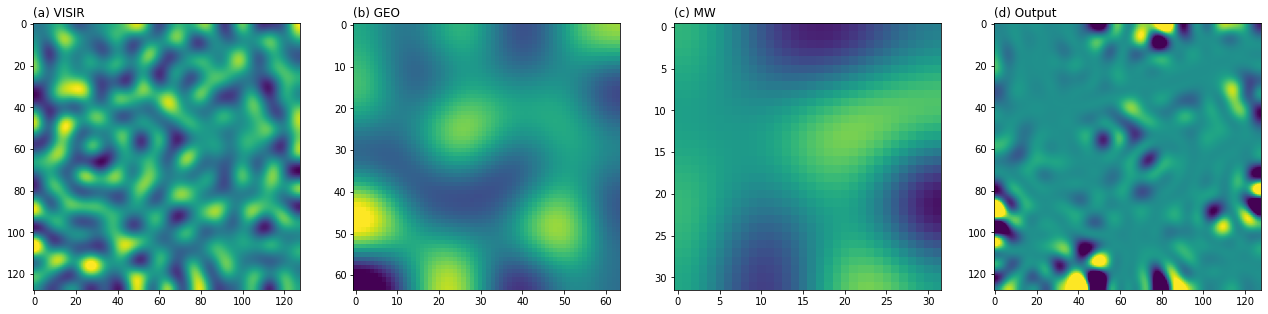

In [11]:
from IPython.display import HTML
ani = validation_data.plot_sample(x, y)
HTML(ani.to_jshtml())

In [17]:
rm -rf lightning_logs/

In [18]:
from cimr.data.training_data import SuperpositionDataset
from cimr.data.training_data import StreamData, sparse_collate
from cimr.models import CIMRNaive
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch import optim
from quantnn.qrnn import QRNN
from quantnn import metrics
    
def run_training(availability, aggregation):
    availability = availability.lower()
    name = f"Aggregation: {aggregation}, availability: {availability}"
    if availability == "full":
        availability = [1.0, 1.0, 1.0]
        sparse = False
    elif availability == "sparse":
        availability = [0.1, 1.0, 0.1]
        sparse = False
    elif availability == "sparse_packed":
        availability = [0.1, 1.0, 0.1]
        sparse = True
    else:
        raise ValueError(
            f"'availability' should be one of ['full', 'sparse', "
            f" 'sparse_packed'] not '{availability}'",
        )
        
        
    training_data = SuperpositionDataset(
        size=128,
        n_samples=1000,
        availability=availability,
        n_steps=1,
        sparse=sparse,
        composition="prod"
    )
    training_loader = DataLoader(
        training_data,
        num_workers=8,
        batch_size=2,
        shuffle=True,
        worker_init_fn=training_data.init_rng,
        collate_fn=sparse_collate
    )
    validation_data = SuperpositionDataset(
        size=128,
        n_samples=100,
        availability=1.0,
        n_steps=1,
        composition="prod"
    )
    validation_loader = DataLoader(
        validation_data,
        num_workers=8,
        batch_size=4,
        shuffle=True,
        worker_init_fn=validation_data.init_rng,
    )

    model = CIMRNaive(3, 1, aggregation=aggregation, block_type="convnext")
    quantiles = np.linspace(0, 1, 66)[1:-1]
    qrnn = QRNN(model=model, quantiles=quantiles )


    mtrx = [
        metrics.Bias(),
        metrics.Correlation(),
        metrics.MeanSquaredError(),
        metrics.ScatterPlot(),
        metrics.CalibrationPlot()
    ]

    lm = qrnn.lightning(mask=-100, metrics=mtrx, name=name)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
    lm.optimizer = optimizer
    lm.scheduler = scheduler

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator="gpu",
        devices=-1,
        precision=32,
        gradient_clip_val=1,
        logger=lm.tensorboard,
        replace_sampler_ddp=True,    
    )
    trainer.fit(
        model=lm,
        train_dataloaders=training_loader,
        val_dataloaders=validation_loader
    )

In [16]:
run_training("sparse_packed", "block")

[13:26:38] INFO     GPU available: True, used: True                                                 ]8;id=449585;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py\trainer.py]8;;\:]8;id=362473;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py#1800\1800]8;;\

           INFO     TPU available: False, using: 0 TPU cores                                        ]8;id=765305;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py\trainer.py]8;;\:]8;id=461075;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py#1805\1805]8;;\

           INFO     IPU available: False, using: 0 IPUs                                             ]8;id=446365;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py\trainer.py]8;;\:]8;id=325159;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py#1808\1808]8;;\

           INFO     HPU available: False, using: 0 HPUs                                             ]8;id=365256;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py\trainer.py]8;;\:]8;id=508990;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py#1811\1811]8;;\

           INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                             ]8;id=262231;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/accelerators/gpu.py\gpu.py]8;;\:]8;id=208999;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/accelerators/gpu.py#57\57]8;;\

           INFO                                                                                 ]8;id=412379;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=38063;file:///home/simonpf/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_summary.py#73\73]8;;\
                      | Name  | Type         | Params                                                              
                    ---------------------------------------                                                        
                    0 | model | CIMRNaive    | 6.9 M                                                               
                    1 | loss  | QuantileLoss | 0                                                                   
                    ---------------------------------------                                                        
                    6.9 M     Trainable params                                                                     
                    0         Non-trainable params                                                                 
                    6.9 M     Total params                                                                         
                    27.512    Total estimated model params size (MB)                                               

Sanity Checking: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

/home/simonpf/src/quantnn/quantnn/metrics.py:676: RuntimeWarning: invalid value encountered in divide
  img /= norm


Epoch 0:   0%|                                                        | 0/525 [00:00<?, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

Epoch 0:  95%|███████████████████████▊ | 500/525 [01:33<00:04,  5.36it/s, loss=0.212, v_num=7]
Validation: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /


Validation DataLoader 0:   0%|                                         | 0/25 [00:00<?, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)



Epoch 1:   0%|                                   | 0/525 [00:00<?, ?it/s, loss=0.212, v_num=7]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

Epoch 1:  95%|███████████████████████▊ | 500/525 [01:34<00:04,  5.28it/s, loss=0.206, v_num=7]
Validation: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /


Validation DataLoader 0:   0%|                                         | 0/25 [00:00<?, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)



Epoch 2:   0%|                                   | 0/525 [00:00<?, ?it/s, loss=0.206, v_num=7]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

Epoch 2:  95%|███████████████████████▊ | 500/525 [01:34<00:04,  5.28it/s, loss=0.204, v_num=7]
Validation: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /


Epoch 3:   0%|                                   | 0/525 [00:00<?, ?it/s, loss=0.204, v_num=7]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

Epoch 3:  95%|███████████████████████▊ | 500/525 [01:34<00:04,  5.28it/s, loss=0.201, v_num=7]
Validation: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /


Validation DataLoader 0:   0%|                                         | 0/25 [00:00<?, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)



Epoch 4:   0%|                                   | 0/525 [00:00<?, ?it/s, loss=0.201, v_num=7]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

Epoch 4:  95%|███████████████████████▊ | 500/525 [01:34<00:04,  5.27it/s, loss=0.204, v_num=7]
Validation: 0it [00:00, ?it/s]

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /


Epoch 4: 100%|█████████████████████████| 525/525 [01:42<00:00,  5.14it/s, loss=0.204, v_num=7]


In [13]:
model = CIMRNaive(4, 2, aggregation="block", block_type="convnext")
model.decoder

SparseSpatialDecoder(
  (upsamplers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
      (1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    )
    (1): Sequential(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    )
    (2): Sequential(
      (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    )
    (3): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(512, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=512)
            (1): Permute()
            (2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          

In [25]:
x, y = next(iter(training_loader))

/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 / np.sqrt(l.reshape(-1, 1) ** 2 + l.reshape(1, -1) ** 2)
/home/simonpf/src/cimr/cimr/data/training_data.py:1376: RuntimeWarning: divide by zero encountered in divide
  l = 1.0 /

In [26]:
x

[{'visir': tensor([[[[-2.8027, -2.5757, -2.1521,  ...,  0.2774,  0.1195,  0.0370],
            [-2.5169, -2.3002, -1.8963,  ...,  0.1908,  0.0471, -0.0279],
            [-1.9944, -1.7971, -1.4306,  ...,  0.0325, -0.0839, -0.1445],
            ...,
            [-0.5669, -0.5198, -0.4238,  ..., -0.9736, -0.9728, -0.9680],
            [-0.1435, -0.1013, -0.0152,  ..., -0.8922, -0.8997, -0.8990],
            [ 0.0878,  0.1273,  0.2077,  ..., -0.8404, -0.8521, -0.8534]],
  
           [[-2.8027, -2.5757, -2.1521,  ...,  0.2774,  0.1195,  0.0370],
            [-2.5169, -2.3002, -1.8963,  ...,  0.1908,  0.0471, -0.0279],
            [-1.9944, -1.7971, -1.4306,  ...,  0.0325, -0.0839, -0.1445],
            ...,
            [-0.5669, -0.5198, -0.4238,  ..., -0.9736, -0.9728, -0.9680],
            [-0.1435, -0.1013, -0.0152,  ..., -0.8922, -0.8997, -0.8990],
            [ 0.0878,  0.1273,  0.2077,  ..., -0.8404, -0.8521, -0.8534]],
  
           [[-2.8027, -2.5757, -2.1521,  ...,  0.2774,  0.119